# Identifying and excluding new cheaters

There is a a flag field 'cheaters' in a table 'users'. 

**Cheaters** are users who, by exploiting vulnerabilities in the game, deposited themselves a considerable amount of in-game currency. Those users do not bring real-world money to the company, but influence data from the A/B test. 

So, the behaviour pattern of the users, who has cheated the game during A/B test, could be described as:

- no entries in the 'money' table, i.e. no real-world money transactions
- but has entries in 'cash' table, i.e. substantial spending of in-game currency

Although, there could be a group of legitimate users who, hypothetically, acquire in-game currency by winning matches, even without spending real-world money.

*The hypothesis is as follows*: cheaters and legitimate users can be differentiated based on their spending volumes.

In this file we look at the behaviour of the known cheaters, seeking for users with the same pattern and exclude them from data analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading data from .csv files and saving it in Pandas DataFrames
users = pd.read_csv('data-processed/users.csv')
money_agg = pd.read_csv('data-processed/money_agg.csv')
cash_agg = pd.read_csv('data-processed/cash_agg.csv')

In [3]:
users.head(3)

,user_id,group,cheaters,platform
0,VX6NLA-F5YMSW,control,0,XBox
1,2AXN3D-71ZN86,test,0,PC
2,K78V3J-TQMV6F,test,0,XBox


In [4]:
money_agg.head(3)

,user_id,money
0,00036L-1T885I,3.97
1,0004MK-MRBUKF,5.95
2,0004MK-VW0O9L,4.96


In [5]:
cash_agg.head(3)

,user_id,cash
0,00036L-1T885I,7600
1,0004MK-MRBUKF,6150
2,0004MK-VW0O9L,6300


## Research of behaviour pattern of known cheaters

In [6]:
# Filtering known cheaters by the flag field and saving them in a separate DataFrame. 
# In total we have 353 entries
cheaters_pattern = users[users['cheaters'] == 1]
cheaters_pattern.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 2158 to 1078318
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   353 non-null    object
 1   group     353 non-null    object
 2   cheaters  353 non-null    int64 
 3   platform  353 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


In [7]:
# Adding data about transactions in real-world money and in-game currency
cheaters_pattern = cheaters_pattern.merge(money_agg, how='left', on='user_id')\
.merge(cash_agg, how='left', on='user_id')

cheaters_pattern.head(3)

,user_id,group,cheaters,platform,money,cash
0,U192N6-HV5KWD,test,1,PC,0.0,136200
1,MMQ51G-SNJR5K,test,1,PC,0.0,181600
2,Q80AK8-1EGHOF,control,1,PC,0.0,101500


In [8]:
# Obtaining basic stats with DataFrame 'describe' method
cheaters_pattern.describe()

,cheaters,money,cash
count,353.0,353.0,353.000000
mean,1.0,0.0,146807.932011
std,0.0,0.0,33800.925081
min,1.0,0.0,46700.000000
25%,1.0,0.0,125100.000000
50%,1.0,0.0,147200.000000
75%,1.0,0.0,169700.000000
max,1.0,0.0,253150.000000


**Conclusion**:  we have confirmed that not a single known cheater has spent real-world money. 

Although, they have conducted transactions in in-game currency with the arithmetic mean of **146 807,93**.  
The range of spending of this cohort of users is from **46 700** to **253 150**.

## Research on other users who do not spend real-world money

In [9]:
# Excluding the known cheaters and saving other users in a separate DataFrame.
others = users[users['cheaters'] == 0]

In [10]:
# Adding data about transactions in real-world money and in-game currency
others_pattern = others.merge(money_agg, how='left', on='user_id').merge(cash_agg, how='left', on='user_id')

In [11]:
others_pattern.head(3)

,user_id,group,cheaters,platform,money,cash
0,VX6NLA-F5YMSW,control,0,XBox,5.96,5050
1,2AXN3D-71ZN86,test,0,PC,4.96,5600
2,K78V3J-TQMV6F,test,0,XBox,3.96,5850


In [12]:
# Selecting users who have not spent real-world money, but have conducted in-game currency transactions
suspected_cheaters = others_pattern[(others_pattern['money'] == 0) & (others_pattern['cash'] > 0)]

In [13]:
suspected_cheaters.head(3)

,user_id,group,cheaters,platform,money,cash
2163,KKGZRW-QJBI02,control,0,PC,0.0,2850
2791,Y3WBZB-HV12ED,control,0,PC,0.0,2700
3442,LI17EU-KC2C5B,test,0,XBox,0.0,4100


In [14]:
# Obtaining basic stats with DataFrame 'describe' method
suspected_cheaters.describe()

,cheaters,money,cash
count,571.0,571.0,571.000000
mean,0.0,0.0,92286.339755
std,0.0,0.0,77170.723115
min,0.0,0.0,200.000000
25%,0.0,0.0,3725.000000
50%,0.0,0.0,117050.000000
75%,0.0,0.0,157775.000000
max,0.0,0.0,240950.000000


It should be noted, that the range of 'cash' data is larger for these users - from **200** to **240 950**.  
And the arithmetic mean **117 050** is lower than the same for cheaters.

Hence, there are presumably two different clusters of users in the 'suspected_cheaters' dataset.  

To confirm this, we will visualize the distribution of values on a histogram.

<Axes: xlabel='cash', ylabel='Count'>

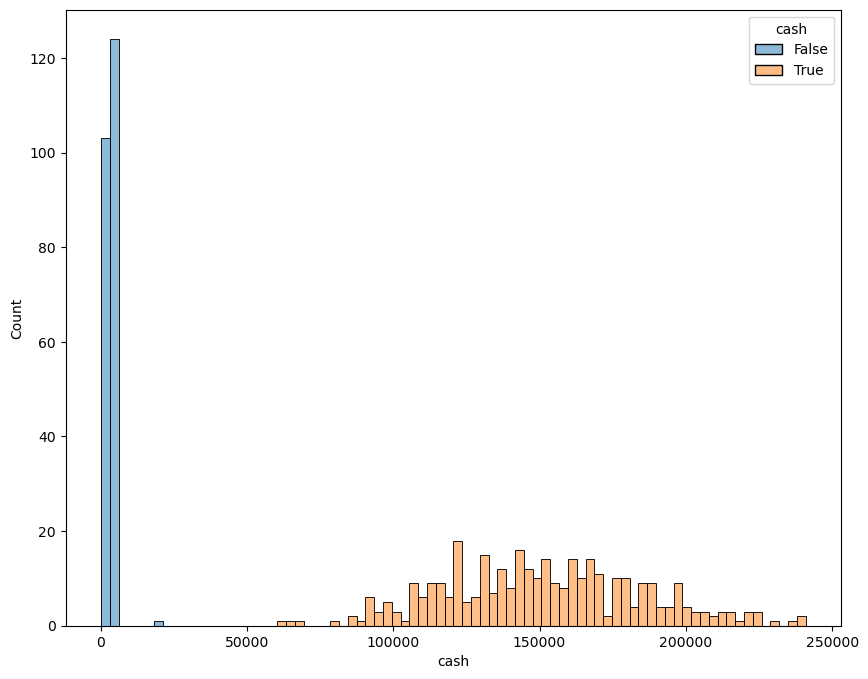

In [15]:
# Using histplot() function from Seaborn library to build a histogram

plt.figure(figsize=(10, 8))
sns.histplot(data=suspected_cheaters['cash'], x=suspected_cheaters['cash'], \
             bins=80, hue=suspected_cheaters['cash'] > 30000)

As expected, we clearly see two clusters of users on the histogram. 

The spending of in-game currency of the orange-colored cluster starts after **50 000** up to **240 950**, which is consistent with the pattern of cheaters we have seen before. 

Let's save two clusters of users to a separate DataFrames for a closer look.

In [16]:
new_cheaters = suspected_cheaters[suspected_cheaters['cash'] > 50000]
new_cheaters.describe()

,cheaters,money,cash
count,343.0,343.0,343.000000
mean,0.0,0.0,151371.865889
std,0.0,0.0,33991.397734
min,0.0,0.0,61950.000000
25%,0.0,0.0,124850.000000
50%,0.0,0.0,150150.000000
75%,0.0,0.0,175875.000000
max,0.0,0.0,240950.000000


In [17]:
decent_players = suspected_cheaters[suspected_cheaters['cash'] < 50000]
decent_players.describe()

,cheaters,money,cash
count,228.0,228.0,228.000000
mean,0.0,0.0,3398.903509
std,0.0,0.0,1500.399691
min,0.0,0.0,200.000000
25%,0.0,0.0,2700.000000
50%,0.0,0.0,3400.000000
75%,0.0,0.0,4050.000000
max,0.0,0.0,20700.000000


Please pay attention to one value - a user who has spending of **20 700** (a maximum value in 'decent_players' cluster).

Hypothetically, this could be an ultra-active legitimate player or a very modest cheater. In a real-life scenario, it would make sense to investigate this case with the security department.

But, to discount this case using only statistical means, we will calculate the deviation of this value from the arithmetic means of both clusters in standard deviation units (std, or σ).

In [18]:
# Selecting the user
unclasterized_user = suspected_cheaters[(suspected_cheaters['cash'] > 10000) & (suspected_cheaters['cash'] < 30000)]
unclasterized_user

,user_id,group,cheaters,platform,money,cash
952929,4DBX3L-2LHKON,control,0,PC,0.0,20700


In [19]:
# Removing user 4DBX3L-2LHKON from 'decent_players' dataset
decent_players = suspected_cheaters[suspected_cheaters['cash'] < 20000]

# Saving standard deviations and arithmetic means of the both groups to variables
std_cheaters = new_cheaters['cash'].std()
mean_cheaters = new_cheaters['cash'].mean()
std_decent = decent_players['cash'].std()
mean_decent = decent_players['cash'].mean()

# Calculating deviation from the means of the both clusters in std of the clusters respectively 
from_decent = (unclasterized_user['cash'] - mean_decent) / std_decent
from_cheaters = (mean_cheaters - unclasterized_user['cash']) / std_cheaters

print('\nFrom legitimate users: ', *from_decent, 'σ')
print('\nFrom cheaters: ', *from_cheaters, 'σ')


From legitimate users:  18.01105245675838 σ

From cheaters:  3.84426280179481 σ


So, the probability of the user **4DBX3L-2LHKON** being a cheater is *higher* than being a legitimate user. 
Therefore, we include that user in a 'new_cheaters' DataFrame

In [20]:
new_cheaters = suspected_cheaters[suspected_cheaters['cash'] >= 20700]

If we exclude these cheaters from DataFrame 'others', from where we have already filtered all the known cheaters, we will have a dataset with all the legitimate users.

In [21]:
# Filtering DataFrame joins. All rows from users_cleaned that do not have a match in 'new_cheaters'
users_cleaned = others[~others['user_id'].isin(new_cheaters['user_id'])]

In [22]:
# Saving cleaned users data
users_cleaned.to_csv('data-processed/users_cleaned.csv', index=False)